In [68]:
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le
from collections import defaultdict


In [110]:
df_raw = pd.read_excel("output/resampled_df_10_min.xlsx", index_col=[0])

In [111]:
start_date = pd.to_datetime(f"2023-01-01 00:00:00")
end_date = pd.to_datetime(f"2023-05-01 23:50:00")
training_window_size = 7
horizon_size = 7
model_features = ["day", "weekday", "hour", "window_block"] # Day = day of the month (0-31), hour = hour of the day (0-24), weekday = day in the week (0-7), window_block = window block in the hour (0-5)

baseline_performance = defaultdict(dict)

In [112]:
df = df_raw[df_raw["time"].between(start_date, end_date)].copy()

label_encoder = le()
df.location = label_encoder.fit_transform(df.location)

In [113]:
df["day"] = df["time"].dt.day
df["weekday"] = df["time"].dt.dayofweek
df["hour"] = df["time"].dt.hour
df["window_block"] = ((df['time'].dt.minute * 60 + df['time'].dt.second) // 600).astype(int)


In [114]:
df.head(10)

,time,location,day,weekday,hour,window_block
20,2023-01-01 03:20:00,4,1,6,3,2
21,2023-01-01 03:30:00,4,1,6,3,3
22,2023-01-01 03:40:00,4,1,6,3,4
23,2023-01-01 03:50:00,4,1,6,3,5
24,2023-01-01 04:00:00,4,1,6,4,0
25,2023-01-01 04:10:00,4,1,6,4,1
26,2023-01-01 04:20:00,4,1,6,4,2
27,2023-01-01 04:30:00,4,1,6,4,3
28,2023-01-01 04:40:00,4,1,6,4,4
29,2023-01-01 04:50:00,4,1,6,4,5


In [115]:
train_start_date = start_date
train_end_date = train_start_date + pd.Timedelta(days=training_window_size-1, hours=23, minutes=50)
test_start_date = train_end_date + pd.Timedelta(minutes=10)
test_end_date = test_start_date + pd.Timedelta(days=horizon_size-1, hours=23, minutes=50)

train_mask = df["time"].between(train_start_date, train_end_date)
test_mask = df["time"].between(test_start_date, test_end_date)

# Split the data into train and test sets
X_train = df.loc[train_mask, model_features]
y_train = df.loc[train_mask, "location"]
X_test = df.loc[test_mask, model_features]
y_test = df.loc[test_mask, "location"]

print(f"Training: {train_start_date}-{train_end_date}, testing: {test_start_date}-{test_end_date}.")

Training: 2023-01-01 00:00:00-2023-01-07 23:50:00, testing: 2023-01-08 00:00:00-2023-01-14 23:50:00.


In [116]:
training_data = df.loc[train_mask]
testing_data = df.loc[test_mask]
most_common_locations = training_data.groupby(model_features)['location'].apply(lambda x: x.value_counts().idxmax()).reset_index()

In [117]:
result_df = testing_data.merge(most_common_locations, how="left", left_on=model_features, right_on=model_features)

features_to_use = model_features[1:]
while result_df['location_y'].isna().sum() > 0:
    print('nan > 0, now trying with features: ', features_to_use)
    most_common_locations = training_data[["location"] + features_to_use].groupby(features_to_use)['location'].apply(lambda x: x.value_counts().idxmax()).reset_index()
    result_df = testing_data.merge(most_common_locations, how="left", left_on=features_to_use, right_on=features_to_use)
    features_to_use = features_to_use[1:]  # Remove the first element to exclude it from the next merge

predictions = result_df.location_y.values.tolist()



nan > 0, now trying with features:  ['weekday', 'hour', 'window_block']
nan > 0, now trying with features:  ['hour', 'window_block']


In [118]:
for d in range(horizon_size):
    # Then, evaluate the baseline's predictions and store acc in self.baseline_performance
    this_day_predictions = predictions[d*144:(d+1)*144]
    this_day_actual_values = y_test[d*144:(d+1)*144]
    acc = accuracy_score(this_day_actual_values, this_day_predictions)
    print(f"Acc of baseline: {acc}")

Acc of baseline: 0.8125
Acc of baseline: 0.0
Acc of baseline: 0.0
Acc of baseline: 0.0
Acc of baseline: 0.0
Acc of baseline: 0.0
Acc of baseline: 0.0


In [129]:
data = {'days_into_future_0': [0.0417, 0.9028, 0.8056, 0.75, 0.8125, 0.0972, 0.6806, 0.0208, 0.9167, 0.9028, 0.8403, 0.8472, 0.0833, 0.9792, 0.0208, 0.8958, 0.6389, 0.6597, 0.5903, 0.0, 0.7014, 0.0486, 0.7153, 0.5764, 0.6389, 0.6528, 0.9306, 0.9306, 0.5486, 0.5486, 0.7986, 0.6806, 0.8056, 0.0278, 0.875, 0.0208, 0.7569, 0.7083, 0.9375, 0.7847, 0.5694, 0.125, 0.6597, 0.1528, 0.5486, 0.7153, 0.7569, 0.0069, 0.9306, 0.0417, 0.875, 0.5694, 0.7708, 0.5903, 0.0, 0.375, 0.4097, 0.6875, 0.1806, 0.8611, 0.9306, 0.9306, 0.6042, 0.2361, 0.9861, 0.9861, 0.7361, 0.9028, 0.6944, 0.7292, 0.0625, 0.5694, 0.6458, 0.7778, 0.8542, 0.9236, 0.9236, 0.6181, 0.6181, 0.625, 0.6667, 0.5417, 0.0694, 0.6806, 0.0486, 0.7361, 0.6667, 0.7014, 0.6111, 0.0833, 0.9097, 0.0903, 0.5833, 0.6389, 0.9028, 0.5417, 0.0903, 0.9375, 0.0625, 0.7014, 0.6736, 0.6111, 0.5417, 0.0694, 0.6667, 0.0417, 0.7153, 0.875, 0.6875, 0.6042, 0.0417, 0.9444, 0.0556, 0.7153, 0.6806, 0.7639, 0.0, 0.4444, 1.0, 0.8333, 0.1667, 0.5486, 0.4861, 0.5903, 0.0694, 0.6389, 0.0556, 0.8611, 0.6597, 0.8681, 0.6667, 0.9375, 1.0, 0.6181, 0.8264, 0.7778, 0.6667, 0.6111, 0.0694, 0.9375, 0.0417, 0.6667, 0.6875, 0.6458, 0.8889, 0.6597, 0.9097, 0.9375, 0.6389, 0.5139, 0.4931, 0.8403, 0.3681, 0.0903, 0.0625, 1.0, 0.6806, 0.9375, 0.4167, 0.2431, 0.5208, 0.0, 0.125, 0.875, 0.9236, 0.6319, 0.8611, 0.9514, 1.0, 0.6042, 0.625, 0.4028, 0.1111], 'days_into_future_1': [0.0417, 0.7917, 0.9028, 0.8264, 0.0972, 0.0208, 0.0972, 0.0208, 0.8889, 0.8819, 0.7986, 0.0, 0.0625, 0.0, 0.0208, 0.6528, 0.5347, 0.7292, 0.0, 0.0139, 0.0, 0.0486, 0.5208, 0.7222, 0.9306, 0.6389, 0.8611, 0.5486, 0.8611, 0.7361, 0.625, 0.7292, 0.0, 0.0069, 0.0, 0.0208, 0.9097, 0.75, 0.7986, 0.6181, 0.0, 0.1319, 0.0, 0.0972, 0.6458, 0.8264, 0.0, 0.0347, 0.0, 0.0417, 0.5833, 0.5417, 0.5625, 0.0, 0.0, 0.9653, 0.4097, 0.0, 0.2292, 0.9306, 0.8611, 0.6736, 0.0, 0.2222, 1.0, 0.7361, 0.7778, 0.6528, 0.6458, 0.0, 0.0625, 0.7014, 0.5694, 0.9236, 0.7917, 1.0, 0.6181, 0.9097, 0.8194, 0.75, 0.8472, 0.0, 0.0, 0.0, 0.0486, 0.8472, 0.7917, 0.5625, 0.0, 0.0069, 0.0, 0.0556, 0.7917, 0.5486, 0.6389, 0.0, 0.0278, 0.0, 0.0625, 0.7847, 0.8958, 0.75, 0.0, 0.0, 0.0, 0.0417, 0.6875, 0.6458, 0.8125, 0.0, 0.0139, 0.0, 0.0556, 0.8333, 0.6458, 0.0, 0.0, 0.4444, 0.8333, 0.0, 0.0833, 0.6667, 0.5556, 0.0, 0.0, 0.0, 0.0556, 0.6181, 0.6806, 0.6875, 0.7083, 0.9375, 0.6181, 0.6528, 0.875, 0.6528, 0.7847, 0.0, 0.0069, 0.0, 0.0417, 0.8611, 0.7847, 0.6597, 0.6458, 0.6597, 0.8472, 0.6458, 0.6389, 0.7917, 0.4653, 0.3958, 0.0625, 0.5347, 0.0625, 0.6806, 0.6597, 0.4375, 0.0, 0.0, 0.0, 0.0, 0.125, 0.9236, 0.6806, 0.6319, 0.8958, 0.9514, 0.6042, 0.9375, 0.7361, 0.0, 0.0], 'days_into_future_2': [0.0417, 0.9306, 0.8958, 0.0972, 0.0208, 0.5694, 0.0972, 0.0208, 0.9097, 0.8403, 0.0, 0.0208, 0.5278, 0.0, 0.0208, 0.5, 0.7847, 0.0, 0.0417, 0.5972, 0.0, 0.0486, 0.5764, 0.5903, 1.0, 0.6389, 0.5625, 0.9306, 0.7292, 0.8125, 0.5972, 0.0, 0.0208, 0.7847, 0.0, 0.0208, 0.9236, 0.6944, 0.6042, 0.0, 0.1875, 0.4861, 0.0, 0.2014, 0.5972, 0.0, 0.0417, 0.5972, 0.0, 0.0417, 0.5556, 0.6875, 0.0, 0.0, 0.0, 0.6528, 0.0, 0.0, 0.25, 0.8611, 0.6389, 0.0, 0.0, 0.2361, 0.7361, 0.7778, 0.9167, 0.6111, 0.0, 0.0, 0.0625, 0.5625, 0.6458, 0.8472, 0.8542, 0.6181, 0.9028, 0.625, 0.5347, 0.6319, 0.0, 0.0486, 0.6319, 0.0, 0.0486, 0.6667, 0.75, 0.0, 0.0903, 0.5903, 0.0, 0.0903, 0.7222, 0.7292, 0.0, 0.0625, 0.6875, 0.0, 0.0625, 0.6597, 0.6389, 0.0, 0.0417, 0.5972, 0.0, 0.0417, 0.7361, 0.7986, 0.0, 0.0556, 0.8819, 0.0, 0.0556, 0.9306, 0.0, 0.0, 0.0, 0.2778, 0.0, 0.0, 0.0, 0.7917, 0.0, 0.0, 0.5556, 0.0, 0.0556, 0.6389, 0.8681, 0.6875, 0.7083, 0.6181, 0.6528, 0.6667, 0.6181, 0.6875, 0.0, 0.0625, 0.5764, 0.0, 0.0625, 0.5833, 0.8611, 0.9861, 0.6458, 0.5972, 0.6458, 0.6389, 0.5625, 0.7639, 0.5347, 0.0625, 0.5486, 0.5347, 0.0625, 0.6597, 0.7569, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.6806, 0.6806, 0.6319, 0.8958, 0.6042, 0.9375, 0.4028, 0.0, 0.0, 0.125], 'days_into_future_3': [0.0417, 0.8403, 0.0972, 0.0208, 0.5278, 0.625, 0.0972, 0.0208, 0.8125, 0.0, 0.0208, 0.5486, 0.5556, 0.0, 0.0208, 0.7292, 0.0, 0.0486, 0.4931, 0.6667, 0.0, 0.0486, 0.5208, 0.5764, 0.9306, 0.7153, 0.9236, 0.7986, 0.5694, 0.7639, 0.0, 0.0208, 0.7431, 0.5972, 0.0, 0.0208, 0.8333, 0.6736, 0.0, 0.1806, 0.6111, 0.6181, 0.0, 0.1667, 0.0, 0.0417, 0.5694, 0.5833, 0.0, 0.0417, 0.8056, 0.0, 0.0, 0.0, 0.2014, 0.0, 0.0, 0.0, 0.25, 0.6736, 0.0, 0.0, 0.0, 0.0556, 0.7778, 0.9028, 0.8125, 0.0, 0.0, 0.0, 0.0625, 0.6389, 0.6458, 0.9236, 0.5417, 0.9097, 0.625, 0.8403, 0.8194, 0.0, 0.0347, 0.7639, 0.8056, 0.0, 0.0486, 0.6319, 0.0, 0.0903, 0.8611, 0.5764, 0.0, 0.0903, 0.5417, 0.0, 0.0625, 0.6667, 0.5972, 0.0, 0.0625, 0.7986, 0.0, 0.0417, 0.7292, 0.8819, 0.0, 0.0417, 0.7153, 0.0, 0.0556, 0.6458, 0.6597, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0972, 0.0, 0.0, 0.0, 0.0972, 0.0, 0.0347, 0.5, 0.5972, 0.0, 0.0556, 0.8681, 0.9306, 0.6875, 0.8403, 0.6528, 0.6667, 0.9375, 0.7292, 0.0, 0.0625, 0.875, 0.7431, 0.0, 0.0625, 0.5972, 0.6875, 0.9236, 0.6111, 0.8056, 0.6389, 0.625, 0.5, 0.4306, 0.0625, 0.625, 0.5486, 0.4375, 0.0625, 0.7569, 0.0, 0.0, 0.125, 0.4583, 0.0, 0.0, 0.125, 0.6806, 0.6806, 0.6319, 0.6042, 0.8889, 0.4028, 0.0, 0.0, 0.0903, 0.4028], 'days_into_future_4': [0.0417, 0.0972, 0.0208, 0.5903, 0.5694, 0.5556, 0.0972, 0.0, 0.0, 0.0208, 0.5972, 0.5694, 0.5833, 0.0, 0.0, 0.0, 0.0486, 0.5208, 0.5417, 0.6806, 0.0, 0.0486, 0.5208, 0.5764, 0.5486, 0.6389, 0.8264, 0.5694, 0.5972, 0.0, 0.0208, 0.8889, 0.5694, 0.7708, 0.0, 0.0208, 0.6111, 0.0, 0.2014, 0.625, 0.8333, 0.4167, 0.0, 0.0, 0.0417, 0.6319, 0.5833, 0.8681, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1458, 0.8125, 0.0, 0.0, 0.0, 0.0139, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.9167, 0.8056, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.6389, 0.6458, 0.6528, 0.7639, 0.625, 0.7639, 0.6319, 0.0, 0.0486, 0.625, 0.6667, 0.625, 0.0, 0.0, 0.0, 0.0903, 0.6319, 0.6042, 0.7361, 0.0, 0.0, 0.0, 0.0556, 0.7292, 0.9306, 0.7639, 0.0, 0.0, 0.0, 0.0417, 0.7847, 0.6111, 0.8542, 0.0, 0.0, 0.0, 0.0556, 0.9306, 0.8403, 0.8403, 0.0, 0.0, 0.0, 0.0, 0.1667, 0.6389, 0.0, 0.0, 0.0, 0.0, 0.0556, 0.8056, 0.5, 0.9167, 0.0, 0.0556, 0.9306, 0.9306, 0.9097, 0.8056, 0.6319, 0.9375, 0.6111, 0.0, 0.0625, 0.6042, 0.6875, 0.6111, 0.0, 0.0625, 0.8472, 0.6875, 0.8611, 0.7292, 0.5486, 0.625, 0.5486, 0.5347, 0.0625, 0.6389, 0.625, 0.8125, 0.3958, 0.0, 0.0, 0.0, 0.125, 0.875, 0.4375, 0.0, 0.0, 0.125, 0.6806, 0.6806, 0.8681, 0.8333, 0.4028, 0.0, 0.0, 0.1111, 0.9375, 0.6597], 'days_into_future_5': [0.7917, 0.0208, 0.5694, 0.6736, 0.6389, 0.5694, 0.0972, 0.0, 0.0208, 0.6528, 0.5556, 0.5833, 0.5139, 0.0, 0.0, 0.0486, 0.7292, 0.5764, 0.5972, 0.5972, 0.0, 0.0486, 0.5208, 0.8819, 0.9306, 0.7569, 0.5694, 0.5972, 0.0, 0.0208, 0.7361, 0.7292, 0.75, 0.75, 0.0, 0.0, 0.0, 0.1944, 0.6042, 0.7986, 0.75, 0.5417, 0.0, 0.0417, 0.6111, 0.6181, 0.6875, 0.6736, 0.0, 0.5903, 0.0, 0.0, 0.1528, 0.5347, 0.8125, 0.0, 0.0, 0.2361, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.2361, 0.8125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.6389, 0.6111, 0.8333, 0.6458, 0.8403, 0.6319, 0.0, 0.0486, 0.9722, 0.8125, 0.7639, 0.7847, 0.0, 0.0, 0.0903, 0.7708, 0.8611, 0.8472, 0.7778, 0.0903, 0.9097, 0.0625, 0.8681, 0.9583, 0.6111, 0.5208, 0.0, 0.0, 0.0417, 0.75, 0.8681, 0.6319, 0.5903, 0.0, 0.0, 0.0556, 0.9167, 0.7847, 0.6458, 0.8542, 0.0, 0.0, 0.0, 0.1667, 0.6528, 0.7847, 0.0, 0.0, 0.0, 0.0556, 0.6389, 0.75, 0.5903, 0.7986, 0.0, 0.0556, 0.9306, 0.6458, 0.8472, 0.9097, 0.875, 0.6111, 0.0, 0.0625, 0.6597, 0.8125, 0.9444, 0.7708, 0.0, 0.0625, 0.9375, 0.625, 0.6458, 0.5694, 0.8333, 0.5486, 0.5347, 0.0625, 0.6458, 0.6389, 0.8819, 0.8472, 0.5347, 0.0, 0.0, 0.125, 0.9375, 0.9583, 0.4028, 0.0, 0.0, 0.125, 0.6806, 0.8611, 0.5694, 0.4028, 0.0, 0.0, 0.1111, 0.6042, 0.6111, 0.4028], 'days_into_future_6': [0.6319, 0.5694, 0.625, 0.5764, 0.5, 0.5764, 0.0, 0.0208, 0.5833, 0.625, 0.5764, 0.6042, 0.5833, 0.0, 0.0208, 0.7986, 0.8472, 0.875, 0.6181, 0.6597, 0.0, 0.0486, 0.7292, 0.5764, 0.7986, 0.6181, 0.5972, 0.0, 0.0208, 0.7778, 0.7778, 0.9236, 0.7083, 0.9028, 0.0, 0.0, 0.1667, 0.6667, 0.8125, 0.7083, 0.9653, 0.0, 0.0, 0.2639, 0.6458, 0.9306, 0.5903, 0.6181, 0.6458, 0.7431, 0.0, 0.2222, 0.5833, 0.6042, 0.8819, 0.0, 0.0, 1.0, 0.6875, 0.0, 0.0, 0.0, 0.0, 0.1736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.8958, 0.6458, 0.5972, 0.8403, 0.6319, 0.0, 0.0486, 0.6181, 0.7361, 0.5972, 0.5347, 0.7292, 0.0, 0.0486, 0.6319, 0.6736, 0.7778, 0.7917, 0.75, 1.0, 0.9722, 0.6389, 0.6111, 0.7014, 0.8958, 0.8056, 0.0, 0.0417, 0.6875, 0.6806, 0.7847, 0.9444, 0.7639, 0.0, 0.0417, 0.7569, 0.7292, 0.7639, 0.5764, 0.0, 0.0, 0.0, 0.1667, 0.9028, 0.75, 0.5, 0.0, 0.0, 0.0, 0.0972, 0.7639, 0.5903, 0.7222, 0.6181, 0.0, 0.0556, 0.5486, 0.5833, 0.8681, 0.7083, 0.5903, 0.0, 0.0625, 0.5556, 0.8958, 0.6667, 0.6458, 0.7708, 0.0, 0.0625, 0.875, 0.9028, 0.6389, 0.75, 0.8403, 0.5347, 0.0625, 0.9375, 0.6458, 0.5347, 0.9028, 0.3681, 0.0, 0.0903, 0.125, 0.6806, 0.9375, 0.9514, 0.6528, 0.0, 0.0, 0.125, 0.8194, 0.6181, 0.7014, 0.0, 0.0, 0.1111, 1.0, 0.8611, 0.8472, 0.0], 'days_into_future_7': [0.0417, 0.6111, 0.5556, 0.5833, 0.4792, 0.0, 0.0, 0.0208, 0.5694, 0.6736, 0.4514, 0.5486, 0.0, 0.0, 0.0208, 0.9028, 0.6389, 0.7014, 0.5556, 0.6806, 0.0, 0.0486, 0.5208, 0.7639, 0.5694, 0.6736, 0.0, 0.0208, 0.7083, 0.5486, 0.7292, 0.9375, 0.8333, 0.5, 0.0, 0.0208, 0.6111, 0.6806, 0.7639, 0.7639, 0.0, 0.0, 0.0, 0.2083, 0.5417, 0.7847, 0.4931, 0.0069, 0.7292, 0.625, 0.2708, 0.8056, 0.6528, 0.6042, 0.8125, 0.2361, 0.4097, 0.9861, 0.6875, 0.0, 0.0, 0.0, 0.0625, 0.4236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.6389, 0.5347, 0.7639, 0.5556, 0.0, 0.0486, 0.9236, 0.8194, 0.8333, 0.7569, 0.5625, 0.0, 0.0, 0.0486, 0.8611, 0.8542, 0.6875, 0.5764, 0.0833, 0.9375, 0.0903, 0.7778, 0.7917, 0.8542, 0.5833, 0.0, 0.0, 0.0625, 0.8472, 0.7361, 0.6458, 0.5694, 0.0, 0.0, 0.0417, 0.6319, 0.75, 0.8611, 0.0, 0.0, 0.0, 0.0556, 0.7083, 0.5625, 0.4861, 0.6944, 0.5556, 0.0, 0.0, 0.1667, 0.8611, 0.5694, 0.4583, 0.625, 0.0, 0.0556, 0.6806, 0.7361, 0.6875, 0.8611, 0.0, 0.0625, 0.9375, 0.8889, 0.6528, 0.9444, 0.6597, 0.6111, 0.0, 0.0625, 0.625, 0.5069, 0.625, 0.8264, 0.4514, 0.0625, 1.0, 0.9375, 0.8611, 0.4931, 0.3958, 0.0, 0.2639, 0.3889, 0.6806, 0.6806, 0.9444, 0.6597, 0.7083, 0.0, 0.0, 0.1111, 0.6181, 0.6597, 0.0, 0.0, 0.1111, 1.0, 0.6736, 0.4931, 0.0, 0.0], 'days_into_future_8': [0.0417, 0.6111, 0.5556, 0.5833, 0.0, 0.0208, 0.0972, 0.0208, 0.5903, 0.5208, 0.5347, 0.0, 0.0, 0.0, 0.0208, 0.6528, 0.7014, 0.8333, 0.5972, 0.6806, 0.0, 0.0486, 0.6528, 0.7986, 0.5972, 0.0, 0.0208, 0.7361, 0.7639, 0.8125, 0.7431, 0.7639, 0.4444, 0.0, 0.0, 0.0208, 0.8472, 0.5417, 0.7778, 0.0, 0.0417, 0.7986, 0.0, 0.1111, 0.6528, 0.5625, 0.0, 0.0, 0.6806, 0.6667, 0.8958, 0.8056, 0.6528, 0.6042, 0.6042, 0.9653, 0.4097, 1.0, 0.6875, 0.0, 0.0, 0.0625, 0.6389, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0625, 0.7847, 0.5486, 0.625, 0.0, 0.0486, 0.9306, 0.7361, 0.6528, 0.6667, 0.7292, 0.0, 0.0208, 0.0, 0.0486, 0.7014, 0.8056, 0.7222, 0.0, 0.0208, 0.0, 0.0903, 0.6319, 0.5486, 0.6806, 0.0, 0.0, 0.0, 0.0625, 0.9444, 0.9514, 0.7431, 0.0, 0.0, 0.0, 0.0417, 0.8056, 0.8472, 0.0, 0.0, 0.0, 0.0, 0.0556, 0.8194, 0.6528, 0.625, 0.0694, 0.5556, 0.0, 0.0, 0.1667, 0.9028, 0.8194, 0.5, 0.625, 0.0, 0.0556, 0.5972, 0.8681, 0.75, 0.0, 0.0625, 0.9375, 0.6875, 0.6181, 0.75, 0.9097, 0.9444, 0.6111, 0.0, 0.0625, 0.5833, 0.8403, 0.5486, 0.4722, 0.0625, 0.9097, 1.0, 0.6181, 0.8542, 0.5417, 0.0, 0.0, 0.0764, 0.0625, 0.6806, 0.6319, 0.6806, 0.6597, 0.7569, 0.0, 0.0, 0.0903, 0.6597, 0.0, 0.0, 0.1111, 0.9514, 0.6736, 0.8819, 0.0, 0.0, 0.0], 'days_into_future_9': [0.0417, 0.5347, 0.5417, 0.0, 0.0208, 0.8264, 0.0972, 0.0208, 0.5208, 0.6042, 0.0, 0.0486, 0.4167, 0.0, 0.0208, 0.7708, 0.6736, 0.875, 0.5972, 0.625, 0.0, 0.0486, 0.7083, 0.8056, 0.0, 0.0208, 0.7847, 0.7986, 0.6736, 0.7569, 0.6806, 0.6736, 0.0, 0.125, 0.0, 0.0208, 0.7222, 0.6597, 0.0, 0.0417, 0.6181, 0.6806, 0.0, 0.0833, 0.5625, 0.0, 0.0, 0.0069, 0.6181, 0.0417, 0.8542, 0.8056, 0.6528, 0.4375, 0.0, 0.9514, 0.4097, 0.7361, 0.6597, 0.0, 0.0625, 0.6389, 0.6458, 0.6736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0347, 0.5556, 0.5625, 0.0, 0.0486, 0.9236, 0.7361, 0.9236, 0.8681, 0.6528, 0.0, 0.0486, 0.7917, 0.0, 0.0486, 0.6111, 0.6319, 0.0, 0.0625, 0.5417, 0.0, 0.0903, 0.8264, 0.7917, 0.0, 0.0417, 0.6042, 0.0, 0.0625, 0.7153, 0.6319, 0.0, 0.0556, 0.8403, 0.0, 0.0417, 0.6875, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0347, 0.5, 0.7708, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1667, 0.6458, 0.8194, 0.5, 0.8264, 0.0, 0.0556, 0.8681, 0.5903, 0.0, 0.0625, 0.875, 0.6875, 0.9236, 0.8542, 0.8264, 0.6667, 0.9375, 0.5486, 0.0, 0.0625, 0.5625, 0.8194, 0.5347, 0.0625, 0.6597, 0.9097, 0.6806, 0.5972, 0.4722, 0.0, 0.0, 0.125, 0.4583, 0.0625, 0.6319, 0.8958, 0.6806, 0.6597, 0.7569, 0.0, 0.0, 0.1111, 0.0, 0.0, 0.1111, 0.8958, 0.6736, 0.8819, 0.0, 0.0, 0.0, 0.0]}

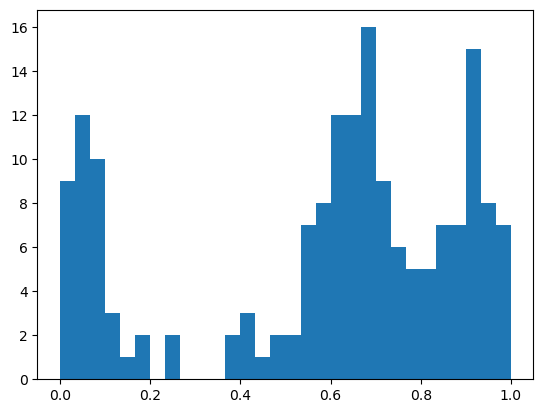

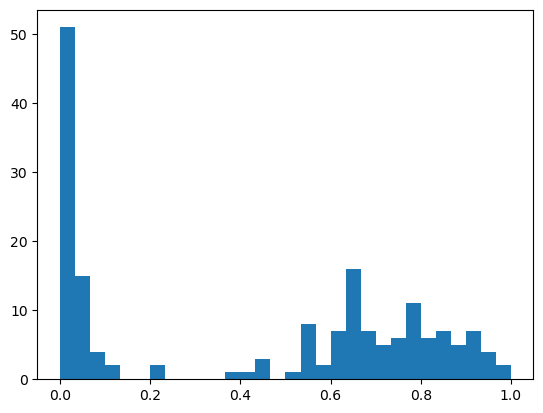

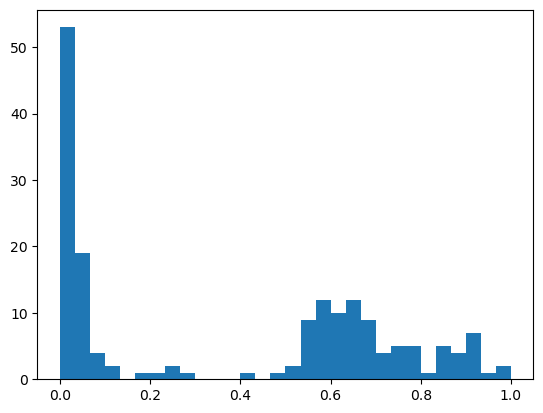

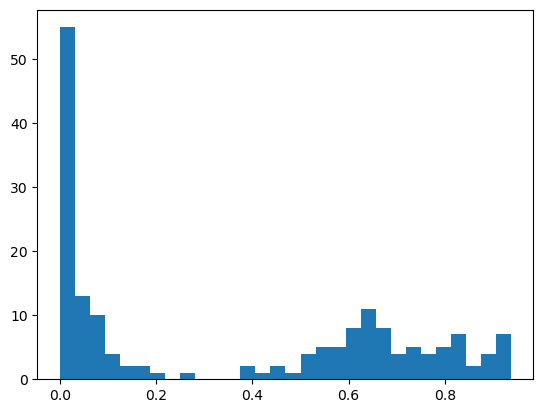

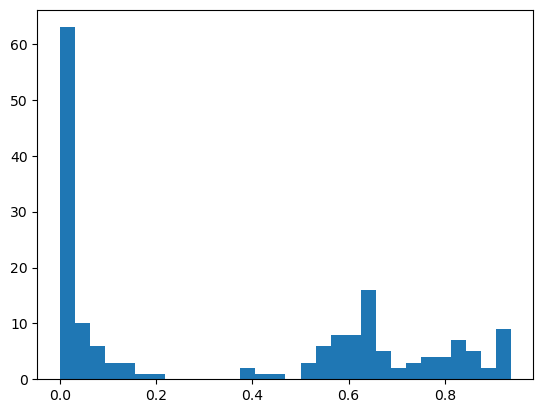

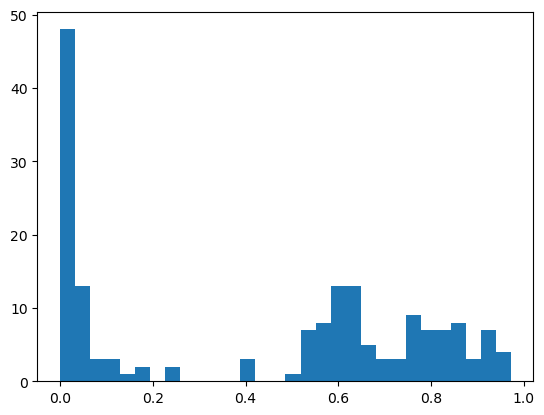

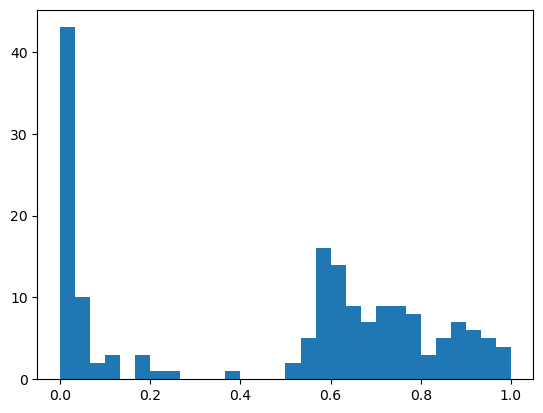

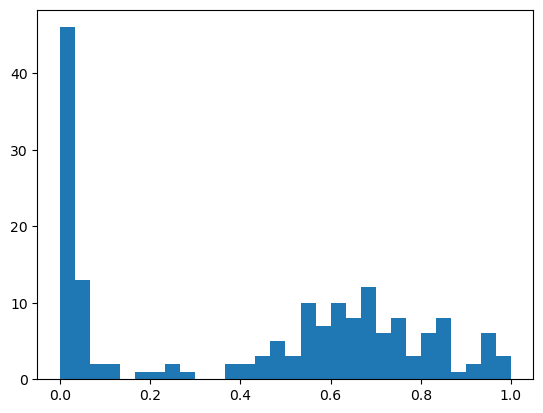

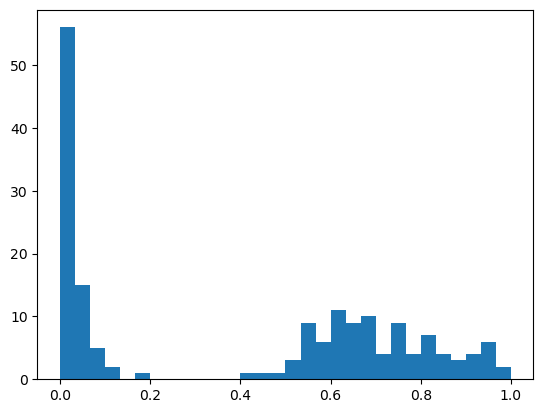

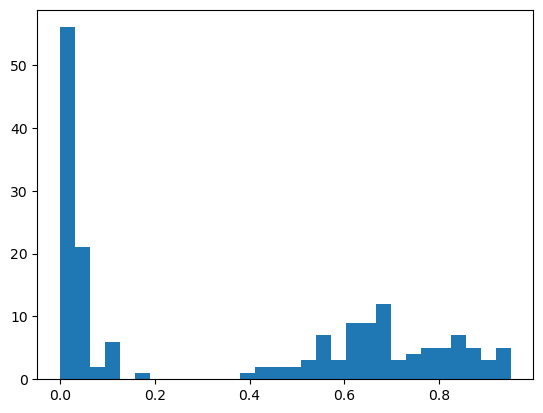

In [131]:
import matplotlib.pyplot as plt

for k,v in data.items():
    plt.hist(v , bins=30)
    plt.show()

In [127]:
import numpy as np

print(np.median(data))
print(np.mean(data))

0.4097
0.36367919075144506
